# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.stats
import matplotlib
import geopandas as gpd
from datetime import datetime, timedelta
import jenkspy
import warnings
import random
warnings.filterwarnings("ignore")

# Define country and parameters

In [29]:
# Select target country
country = 'Chile'

# Set country-specific parameters: ISO codes and buffer size (in meters)
if country == 'Argentina':
    country_short = 'ARG'   # ISO 3-letter code
    country_code = 'AR'     # ISO 2-letter code
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
# Uncomment the following if Mexico is to be included in the analysis
# elif country == 'Mexico':
#     country_short = 'MEX'
#     country_code = 'MX'

# Set working directory

In [30]:
# Define working directory path
wd = (
#     '/your/path/to/working/directory/'
    '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/research/latin-mobility-covid'
)

# Choose category type: density or rdi

In [31]:
# Change to 'density' or 'rdi'
category = 'rdi'

# Is stringenty index used as predictor?

In [32]:
stringency = False

In [33]:
if stringency == True:
    df = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_outflows_param_tidy_results_os_new.csv')
    df_m3_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m3os_re_new.csv')
    df_m4_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m4os_re_new.csv')
    df_m5_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m5os_re_new.csv')
    df_m6_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m6os_re_new.csv')
    df_m7_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m7os_re_new.csv')

else:
    df = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_outflows_param_tidy_results_o_new.csv')
    df_m3_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m3o_re_new.csv')
    df_m4_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m4o_re_new.csv')
    df_m5_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m5o_re_new.csv')
    df_m6_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m6o_re_new.csv')
    df_m7_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_quad_m7o_re_new.csv')


# Select model
Choose between Model 5 or 6
- Model 5: Doesn't include quadratic effects. Random intercept and linear time term. Use when model 6 doesn't converge.
- Model 6: Includes quadratic time term with fixed effects only. Random intercept and linear time term.

In [39]:
model = 6

# Filter dataframe for the selected model and reset index
df_model = df[df['model'] == model].reset_index(drop=True)

# Extract fixed effect intercept estimate
fe_intercept = (
    df_model[df_model['term'].str.contains('Intercept')]['estimate']
    .reset_index(drop=True)
    .loc[0]
)

# Depending on model, extract random effects intercept and sum with fixed effect
if model == 6:
    re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
    intercept = [
        fe_intercept + re_intercept['estimate'].loc[i]
        for i in range(len(np.unique(df_m6_re['term'])))
    ]
elif model == 5:
    re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)
    intercept = [
        fe_intercept + re_intercept['estimate'].loc[i]
        for i in range(len(np.unique(df_m5_re['term'])))
    ]

# Extract fixed effect slope estimate for 'time'
fe_slope = df_model[df_model['term'] == 'time']['estimate'].reset_index(drop=True).loc[0]

# Extract random effects slope and add to fixed effect slope per model
if model == 6:
    re_slope = df_m6_re[df_m6_re['facet'] == 'time'].reset_index(drop=True)
    slope = [
        fe_slope + re_slope['estimate'].loc[i]
        for i in range(len(np.unique(df_m6_re['term'])))
    ]
elif model == 5:
    re_slope = df_m5_re[df_m5_re['facet'] == 'time'].reset_index(drop=True)
    slope = [
        fe_slope + re_slope['estimate'].loc[i]
        for i in range(len(np.unique(df_m5_re['term'])))
    ]

# Try to get fixed effect of 'stringency_index'; if missing, default to 0
try:
    stringency = [
        df_model[df_model['term'] == 'stringency_index']['estimate']
        .reset_index(drop=True)
        .loc[0]
        for _ in range(len(intercept))
    ]
except KeyError:
    stringency = [0 for _ in range(len(intercept))]

# Add stringency effect to slope estimates
slope = [slope[i] + stringency[i] for i in range(len(slope))]

# Extract quadratic term estimates if model 6
if model == 6:
    quad = [
        df_model[df_model['term'] == 'time2']['estimate']
        .reset_index(drop=True)
        .loc[0]
        for _ in range(len(intercept))
    ]

# Fixed effect intercept standard error
fe_intercept_std = (
    df_model[df_model['term'].str.contains('Intercept')]['std.error']
    .reset_index(drop=True)
    .loc[0]
)

# Extract random effects intercept for standard error calculation
if model == 6:
    re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
elif model == 5:
    re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)

# Calculate confidence interval width for random intercept
re_intercept_ci = [
    re_intercept.loc[i, 'conf.high'] - re_intercept.loc[i, 'conf.low']
    for i in range(len(re_intercept))
]

# Convert CI width to standard deviation assuming Gaussian distribution
re_intercept_std = [ci / (2 * 1.96) for ci in re_intercept_ci]

# Combine fixed effect and random effect intercept standard deviations
# Commented out original combination including random std; using only fixed effect std here
# intercept_std = [np.sqrt(fe_intercept_std ** 2 + std ** 2) for std in re_intercept_std]
intercept_std = [np.sqrt(fe_intercept_std ** 2) for _ in re_intercept_std]

# Fixed effect slope standard error
fe_time_std = df_model[df_model['term'] == 'time']['std.error'].reset_index(drop=True).loc[0]

# Try to extract fixed effect stringency standard error; default to 0 if missing
try:
    fe_stringency_std = (
        df_model[df_model['term'] == 'stringency_index']['std.error']
        .reset_index(drop=True)
        .loc[0]
    )
except KeyError:
    fe_stringency_std = 0

# Extract random effects slope standard errors per model
if model == 6:
    re_time = df_m6_re[df_m6_re['facet'].str.contains('time')].reset_index(drop=True)
elif model == 5:
    re_time = df_m5_re[df_m5_re['facet'].str.contains('time')].reset_index(drop=True)

# Calculate confidence interval width for random slope
re_time_ci = [
    re_time.loc[i, 'conf.high'] - re_time.loc[i, 'conf.low']
    for i in range(len(re_time))
]

# Convert CI width to standard deviation assuming Gaussian distribution
re_time_std = [ci / (2 * 1.96) for ci in re_time_ci]

# Combine fixed effects and random effects slope standard deviations
# Commented out combination including random std; using fixed effect std only here
# slope_std = [np.sqrt(fe_time_std ** 2 + fe_stringency_std ** 2 + std ** 2) for std in re_time_std]
slope_std = [np.sqrt(fe_time_std ** 2 + fe_stringency_std ** 2) for _ in re_time_std]

# Extract fixed effect quadratic term standard error for model 6; else zero
if model == 6:
    fe_quad_std = df_model[df_model['term'] == 'time2']['std.error'].reset_index(drop=True).loc[0]
else:
    fe_quad_std = 0

# Create list of quadratic term standard errors
quad_std = [fe_quad_std for _ in range(len(slope_std))]

# Compute recovery times at recovery thresholds 1-100%
Compute also the propagated uncertainties of these times, based on uncertainty of model estimates

In [40]:
thresholds = np.arange(1, 100)
times = []
times_std = []

for thr in thresholds:
    times_thr = []
    times_thr_std = []
    for i in range(len(intercept)):
        # If intercept and slope are both positive, append -1 (special case)
        if intercept[i] > 0 and slope[i] > 0:
            times_thr.append(-1)
        else:
            if model == 6:
                discriminant = slope[i]**2 - 4 * quad[i] * (thr / 100) * intercept[i]

                # Check if discriminant is non-negative for real roots
                if discriminant >= 0:
                    sqrt_discriminant = np.sqrt(discriminant)
                    # Calculate first root
                    time_thr = (-slope[i] + sqrt_discriminant) / (2 * quad[i])
                    if time_thr > 0:
                        times_thr.append(time_thr)

                        partial_intercept = (-(thr / 100)) / sqrt_discriminant
                        partial_slope = (1 / quad[i]) * (-1 + slope[i] / sqrt_discriminant)
                        partial_quad = (-(thr / 100) * intercept[i]) / (quad[i] * sqrt_discriminant) + \
                            (slope[i] - sqrt_discriminant) / (2 * quad[i]**2)
                    else:
                        # Calculate second root if first root not positive
                        time_thr = (-slope[i] - sqrt_discriminant) / (2 * quad[i])
                        times_thr.append(time_thr)

                        partial_intercept = (thr / 100) / sqrt_discriminant
                        partial_slope = (1 / quad[i]) * (-1 - slope[i] / sqrt_discriminant)
                        partial_quad = ((thr / 100) * intercept[i]) / (quad[i] * sqrt_discriminant) + \
                            (slope[i] + sqrt_discriminant) / (2 * quad[i]**2)

                    # Calculate standard deviation of time_thr by error propagation
                    time_thr_std = np.sqrt(
                        (partial_intercept * intercept_std[i]) ** 2 +
                        (partial_slope * slope_std[i]) ** 2 +
                        (partial_quad * quad_std[i]) ** 2
                    )
                    times_thr_std.append(time_thr_std)
                else:
                    # If no real root, append NaN
                    times_thr.append(np.nan)
                    times_thr_std.append(np.nan)

            elif model == 5:
                # Linear model time threshold calculation
                time_thr = - (thr / 100) * (intercept[i] / slope[i])
                times_thr.append(time_thr)

                partial_intercept = -(thr / 100) / slope[i]
                partial_slope = ((thr / 100) * intercept[i]) / (slope[i] ** 2)

                # Standard deviation calculation for linear model
                time_thr_std = np.sqrt(
                    (partial_intercept * intercept_std[i]) ** 2 +
                    (partial_slope * slope_std[i]) ** 2
                )
                times_thr_std.append(time_thr_std)

    times.append(times_thr)
    times_std.append(times_thr_std)

# Convert lists to numpy arrays and transpose
times = np.array(times).T
times_std = np.array(times_std).T

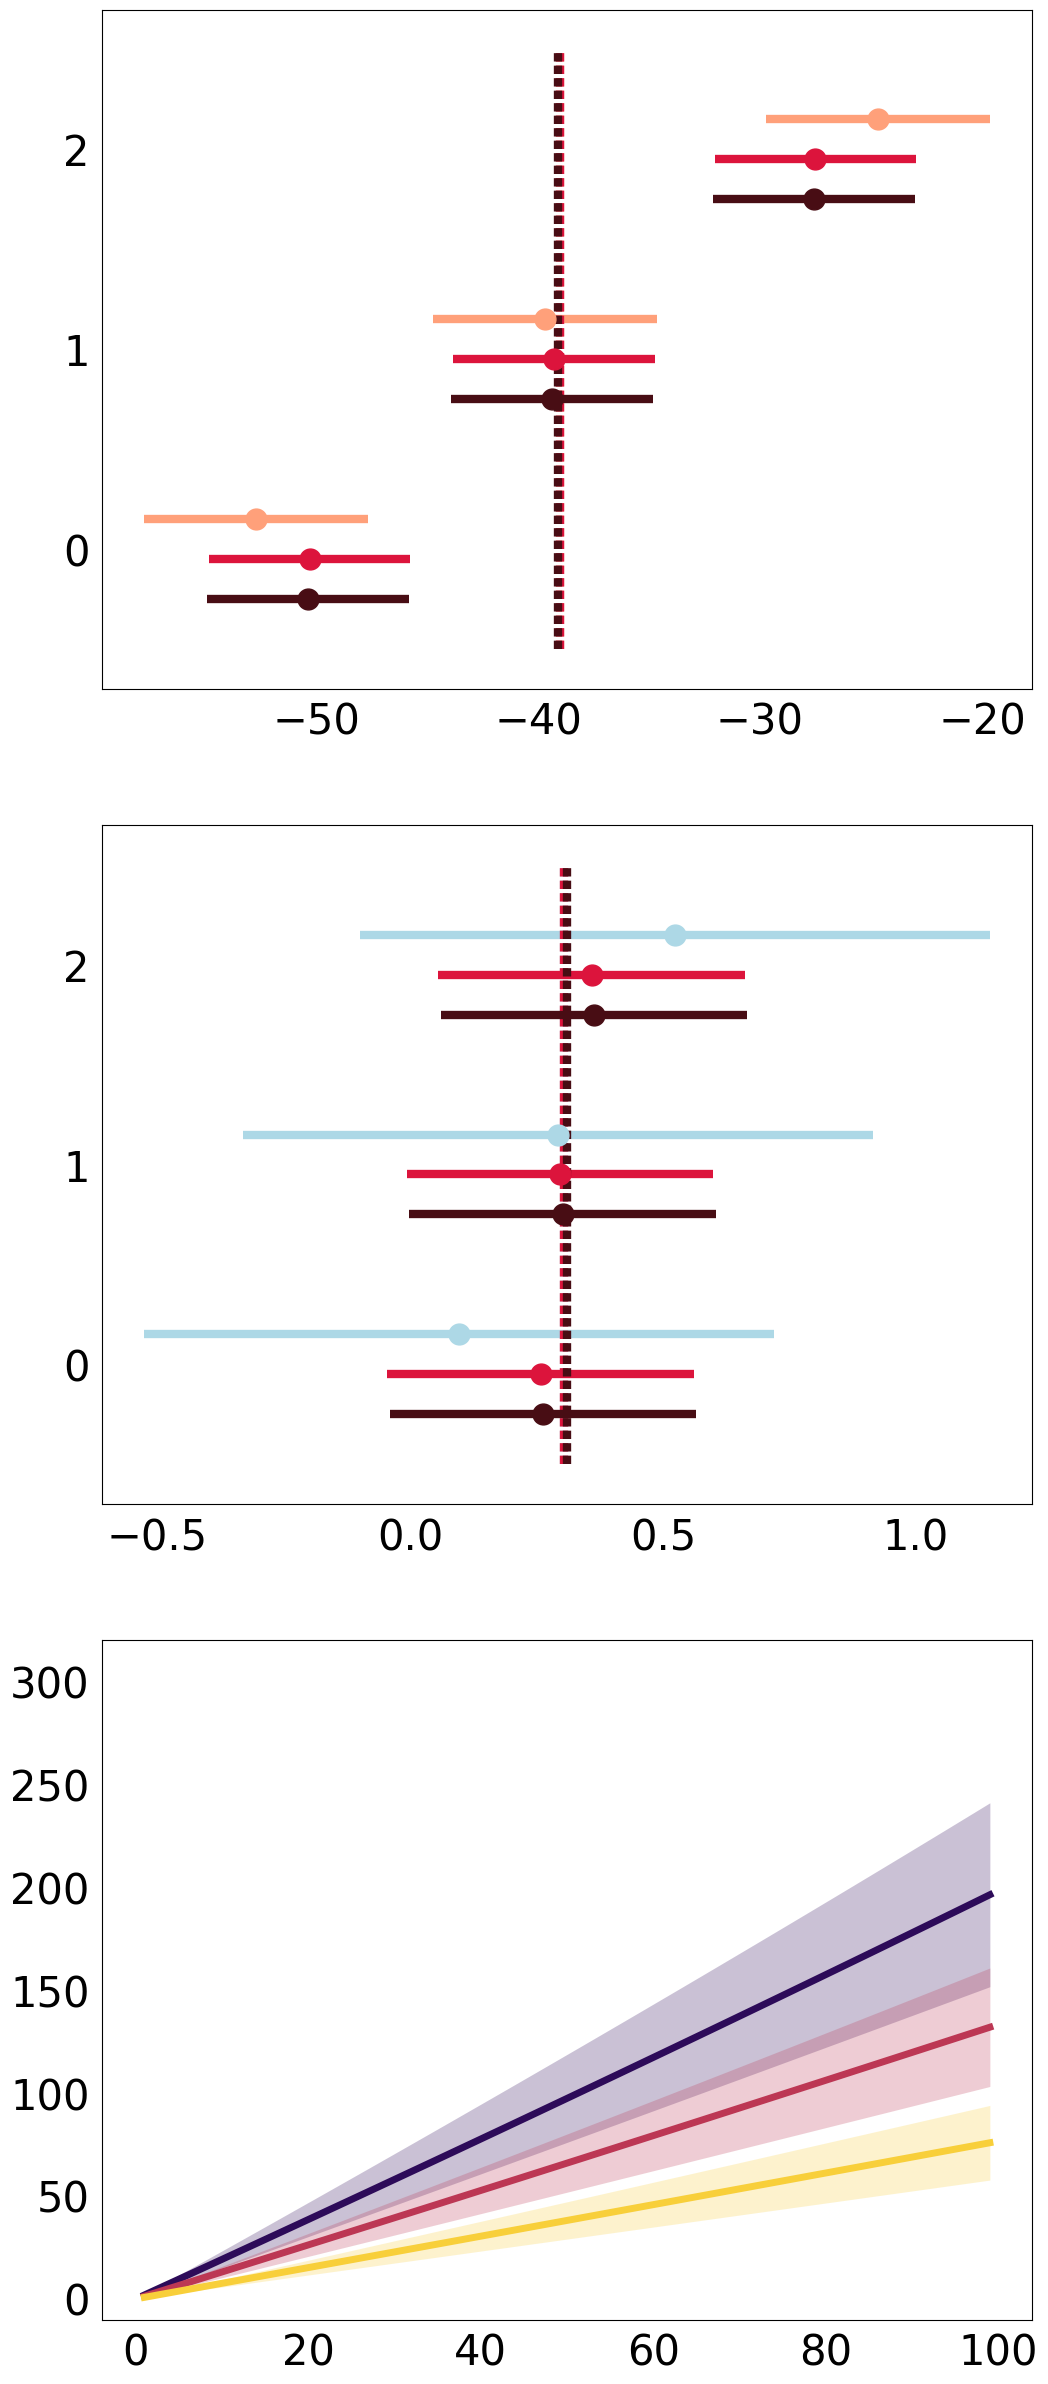

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 30))

# AX1 configuration and plotting
ax1.tick_params(axis='both', which='both', width=0, length=0, color='k', labelsize=30, pad=9)

left_error = df_m3_re['estimate'] - df_m3_re['conf.low']
right_error = df_m3_re['conf.high'] - df_m3_re['estimate']
estimate = df[(df['model'] == 3) & (df['term'] == '(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(
    df_m3_re['estimate'] + estimate.loc[0],
    list(df_m3_re.index + 0.15),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color='lightsalmon'
)
ax1.plot(
    [estimate, estimate],
    [min(list(df_m3_re.index)) - 0.5, max(list(df_m3_re.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color='lightsalmon'
)

df_m5_re_intercept = df_m5_re[df_m5_re['facet'].str.contains('Intercept')].reset_index(drop=True)
left_error = df_m5_re_intercept['estimate'] - df_m5_re_intercept['conf.low']
right_error = df_m5_re_intercept['conf.high'] - df_m5_re_intercept['estimate']
estimate = df[(df['model'] == 5) & (df['term'] == '(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(
    df_m5_re_intercept['estimate'] + estimate.loc[0],
    list(df_m5_re_intercept.index - 0.05),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color='crimson'
)
ax1.plot(
    [estimate, estimate],
    [min(list(df_m5_re_intercept.index)) - 0.5, max(list(df_m5_re_intercept.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color='crimson'
)

df_m6_re_intercept = df_m6_re[df_m6_re['facet'].str.contains('Intercept')].reset_index(drop=True)
left_error = df_m6_re_intercept['estimate'] - df_m6_re_intercept['conf.low']
right_error = df_m6_re_intercept['conf.high'] - df_m6_re_intercept['estimate']
estimate = df[(df['model'] == 6) & (df['term'] == '(Intercept)')]['estimate'].reset_index(drop=True)
ax1.errorbar(
    df_m6_re_intercept['estimate'] + estimate.loc[0],
    list(df_m6_re_intercept.index - 0.25),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color=(72 / 255, 13 / 255, 20 / 255)
)
ax1.plot(
    [estimate, estimate],
    [min(list(df_m6_re_intercept.index)) - 0.5, max(list(df_m6_re_intercept.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color=(72 / 255, 13 / 255, 20 / 255)
)

# Uncomment below for model 7 intercept plotting if needed
# df_m7_re_intercept = df_m7_re[df_m7_re['facet'].str.contains('Intercept')].reset_index(drop=True)
# left_error = df_m7_re_intercept['estimate'] - df_m7_re_intercept['conf.low']
# right_error = df_m7_re_intercept['conf.high'] - df_m7_re_intercept['estimate']
# estimate = df[(df['model'] == 7) & (df['term'] == '(Intercept)')]['estimate'].reset_index(drop=True)
# ax1.errorbar(
#     df_m7_re_intercept['estimate'] + estimate.loc[0],
#     list(df_m7_re_intercept.index - 0.45),
#     xerr=[left_error, right_error],
#     fmt='o',
#     linewidth=6,
#     markersize=15,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )
# ax1.plot(
#     [estimate, estimate],
#     [min(list(df_m7_re_intercept.index)) - 0.5, max(list(df_m7_re_intercept.index)) + 0.5],
#     linestyle=':',
#     dashes=(1, 0.5),
#     linewidth=6,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )

ax1.set_ylim(min(list(df_m5_re_intercept.index)) - 0.7, max(list(df_m5_re_intercept.index)) + 0.7)
ax1.set_yticks(list(df_m5_re_intercept.index), list(df_m5_re_intercept.index))

# AX2 configuration and plotting
ax2.tick_params(axis='both', which='both', width=0, length=0, color='k', labelsize=30, pad=9)

left_error = df_m4_re['estimate'] - df_m4_re['conf.low']
right_error = df_m4_re['conf.high'] - df_m4_re['estimate']
estimate = df[(df['model'] == 2) & (df['term'] == 'time')]['estimate'].reset_index(drop=True)
ax2.errorbar(
    df_m4_re['estimate'] + estimate.loc[0],
    list(df_m4_re.index + 0.15),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color='lightblue'
)
ax2.plot(
    [estimate, estimate],
    [min(list(df_m4_re.index)) - 0.5, max(list(df_m4_re.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color='lightblue'
)

df_m5_re_slope = df_m5_re[df_m5_re['facet'] == 'time'].reset_index(drop=True)
left_error = df_m5_re_slope['estimate'] - df_m5_re_slope['conf.low']
right_error = df_m5_re_slope['conf.high'] - df_m5_re_slope['estimate']
estimate = df[(df['model'] == 5) & (df['term'] == 'time')]['estimate'].reset_index(drop=True)
ax2.errorbar(
    df_m5_re_slope['estimate'] + estimate.loc[0],
    list(df_m5_re_slope.index - 0.05),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color='crimson'
)
ax2.plot(
    [estimate, estimate],
    [min(list(df_m5_re_slope.index)) - 0.5, max(list(df_m5_re_slope.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color='crimson'
)

df_m6_re_slope = df_m6_re[df_m6_re['facet'] == 'time'].reset_index(drop=True)
left_error = df_m6_re_slope['estimate'] - df_m6_re_slope['conf.low']
right_error = df_m6_re_slope['conf.high'] - df_m6_re_slope['estimate']
estimate = df[(df['model'] == 6) & (df['term'] == 'time')]['estimate'].reset_index(drop=True)
ax2.errorbar(
    df_m6_re_slope['estimate'] + estimate.loc[0],
    list(df_m6_re_slope.index - 0.25),
    xerr=[left_error, right_error],
    fmt='o',
    linewidth=6,
    markersize=15,
    color=(72 / 255, 13 / 255, 20 / 255)
)
ax2.plot(
    [estimate, estimate],
    [min(list(df_m6_re_slope.index)) - 0.5, max(list(df_m6_re_slope.index)) + 0.5],
    linestyle=':',
    dashes=(1, 0.5),
    linewidth=6,
    color=(72 / 255, 13 / 255, 20 / 255)
)

# Uncomment below for model 7 slope plotting if needed
# df_m7_re_slope = df_m7_re[df_m7_re['facet']=='time'].reset_index(drop=True)
# left_error = df_m7_re_slope['estimate'] - df_m7_re_slope['conf.low']
# right_error = df_m7_re_slope['conf.high'] - df_m7_re_slope['estimate']
# estimate = df[(df['model']==7) & (df['term']=='time')]['estimate'].reset_index(drop=True)
# ax2.errorbar(
#     df_m7_re_slope['estimate'] + estimate.loc[0],
#     list(df_m7_re_slope.index-0.45),
#     xerr=[left_error, right_error],
#     fmt='o',
#     linewidth=6,
#     markersize=15,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )
# ax2.plot(
#     [estimate, estimate],
#     [min(list(df_m7_re_slope.index)) - 0.5, max(list(df_m7_re_slope.index)) + 0.5],
#     linestyle=':',
#     dashes=(1, 0.5),
#     linewidth=6,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )

ax2.set_ylim(min(list(df_m5_re_intercept.index)) - 0.7, max(list(df_m5_re_intercept.index)) + 0.7)
ax2.set_yticks(list(df_m5_re_slope.index), list(df_m5_re_slope.index))

# AX3 configuration and plotting
ax3.tick_params(axis='both', which='both', width=0, length=0, color='k', labelsize=30, pad=9)

# Uncomment below for model 7 quadratic term plotting if needed
# df_m7_re_quad = df_m7_re[df_m7_re['facet']=='time2'].reset_index(drop=True)
# left_error = df_m7_re_quad['estimate'] - df_m7_re_quad['conf.low']
# right_error = df_m7_re_quad['conf.high'] - df_m7_re_quad['estimate']
# estimate = df[(df['model'] == 7) & (df['term'] == 'time2')]['estimate'].reset_index(drop=True)
# ax3.errorbar(
#     df_m7_re_quad['estimate'] + estimate.loc[0],
#     list(df_m7_re_quad.index),
#     xerr=[left_error, right_error],
#     fmt='o',
#     linewidth=6,
#     markersize=15,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )
# ax3.plot(
#     [estimate, estimate],
#     [min(list(df_m7_re_quad.index)) - 0.5, max(list(df_m7_re_quad.index)) + 0.5],
#     linestyle=':',
#     dashes=(1, 0.5),
#     linewidth=6,
#     color=(72 / 255, 13 / 255, 20 / 255)
# )
# ax3.set_ylim(min(list(df_m7_re_quad.index)) - 0.7, max(list(df_m7_re_quad.index)) + 0.7)
# ax3.set_yticks(list(df_m7_re_quad.index), list(df_m7_re_quad.index))
# xticks = [round(tick * 10, 2) for tick in ax3.get_xticks()]
# ax3.set_xticks(list([tick for tick in ax3.get_xticks()]), xticks)
# ax3.text(0.9, -0.14, 'x 10e-1', fontsize=20, transform=ax3.transAxes)

ax3.set_ylim([-10, 320])

if category == 'density':
    viridis = plt.cm.get_cmap('viridis')
    n_class = len(np.unique(df_m6_re['term']))
    norm = plt.Normalize(0, n_class - 1)
    for i in range(n_class):
        if np.sum(times[i]) > 0:
            ax3.plot(thresholds, times[i], color=viridis(norm(i)), lw=5)
            ax3.fill_between(thresholds, times[i] - times_std[i], times[i] + times_std[i], color=viridis(norm(i)), lw=0, alpha=0.25)
elif category == 'rdi':
    cmap_base = matplotlib.colormaps.get_cmap('inferno')
    if n_class == 3:
        # mimic your [4, 13, 23] sampling
        idx = [4, 13, 23]
        colors_rdi = [cmap_base(i / 26) for i in idx]
    else:
        # general case: evenly spaced colors in the mid-range
        colors_rdi = [cmap_base(x) for x in np.linspace(0.15, 0.85, n_class)]
    for i in range(n_class):
        if np.sum(times[i]) > 0:
            ax3.plot(thresholds, times[i], color=colors_rdi[i], lw=5)
            ax3.fill_between(thresholds, times[i] - times_std[i], times[i] + times_std[i], color=colors_rdi[i], lw=0, alpha=0.25)

if stringency == True: 
    plt.savefig(
        wd + '/plots/evolution/models/' + country_short + '_models_re_' + category + '_quad_stringency_no_m7_std-r1.pdf',
        bbox_inches='tight'
    )
else:
        plt.savefig(
        wd + '/plots/evolution/models/' + country_short + '_models_re_' + category + '_quad_no_m7_std-r1.pdf',
        bbox_inches='tight'
    )

plt.show()


# Compute recovery times at recovery thresholds: 25, 50, 75, 100
Compute also the propagated uncertainties of these times, based on uncertainty of model estimates

In [37]:
thresholds = [25, 50, 75, 100]
times = []
times_std = []

for thr in thresholds:
    times_thr = []
    times_thr_std = []
    for i in range(len(intercept)):
        if intercept[i] > 0 and slope[i] > 0:
            times_thr.append(-1)
            times_thr_std.append(-1)
        else:
            if model == 6:
                discriminant = slope[i]**2 - 4 * quad[i] * (thr / 100) * intercept[i]
                if discriminant >= 0:
                    time_thr = (-slope[i] + np.sqrt(discriminant)) / (2 * quad[i])
                    if time_thr > 0:
                        times_thr.append(time_thr)
                        partial_intercept = (-(thr / 100)) / np.sqrt(discriminant)
                        partial_slope = (1 / quad[i]) * (-1 + (slope[i] / np.sqrt(discriminant)))
                        partial_quad = (-(thr / 100) * intercept[i]) / (quad[i] * np.sqrt(discriminant)) + \
                                       (slope[i] - np.sqrt(discriminant)) / (2 * quad[i]**2)
                    else:
                        time_thr = (-slope[i] - np.sqrt(discriminant)) / (2 * quad[i])
                        times_thr.append(time_thr)
                        partial_intercept = (thr / 100) / np.sqrt(discriminant)
                        partial_slope = (1 / quad[i]) * (-1 - (slope[i] / np.sqrt(discriminant)))
                        partial_quad = ((thr / 100) * intercept[i]) / (quad[i] * np.sqrt(discriminant)) + \
                                       (slope[i] + np.sqrt(discriminant)) / (2 * quad[i]**2)

                    time_thr_std = np.sqrt(
                        (partial_intercept * intercept_std[i])**2 +
                        (partial_slope * slope_std[i])**2 +
                        (partial_quad * quad_std[i])**2
                    )
                    times_thr_std.append(time_thr_std)
                else:
                    times_thr.append(np.nan)
                    times_thr_std.append(np.nan)

            elif model == 5:
                time_thr = - (thr / 100) * (intercept[i] / slope[i])
                times_thr.append(time_thr)
                partial_intercept = -(thr / 100) / slope[i]
                partial_slope = ((thr / 100) * intercept[i]) / (slope[i]**2)
                time_thr_std = np.sqrt(
                    (partial_intercept * intercept_std[i])**2 +
                    (partial_slope * slope_std[i])**2
                )
                times_thr_std.append(time_thr_std)

    times.append(times_thr)
    times_std.append(times_thr_std)

print(times)
print(times_std)


[[48.68844581289051, 33.11245880673619, 19.16490697553347], [97.37689162578101, 66.22491761347239, 38.32981395106694], [146.06533743867152, 99.33737642020859, 57.49472092660041], [194.75378325156203, 132.44983522694477, 76.65962790213388]]
[[6.887365763947503, 5.259847532379408, 3.9571202914954897], [13.774731527895007, 10.519695064758816, 7.914240582990979], [20.66209729184251, 15.779542597138223, 11.87136087448647], [27.549463055790014, 21.03939012951763, 15.828481165981959]]
